<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/evaluation/multi_modal/multi_modal_rag_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating Multi-Modal RAG

In this notebook guide, we'll demonstrate how to evaluate a Multi-Modal RAG system. As in the text-only case, we will consider the evaluation of Retrievers and Generators separately. As we alluded in our [blog](https://fix-me.link) on the topic of Evaluating Multi-Modal RAGs, our approach here involves the application of adapted versions of the usual techniques for evaluating both Retriever and Generator (used for the text-only case). These adapted versions are part of the `llama-index` library (i.e., `evaluation` module), and this notebook will walk you through how you can apply them to your evaluation use-cases.

NOTE: the use-case and its evaluation conducted here is purely illustrative, merely meant to demonstrate how one can apply our evaluation tools to their specific needs. And, by no means, are the results or analyses conducted here meant to be rigorous — though we believe our tools can help you apply increased standard levels of care for your applications.

In [ ]:
%pip install llama-index-llms-openai
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-multi-modal-llms-replicate

In [ ]:
# %pip install llama_index ftfy regex tqdm -q
# %pip install git+https://github.com/openai/CLIP.git -q
# %pip install torch torchvision -q
# %pip install matplotlib scikit-image -q
# %pip install -U qdrant_client -q

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

## Use Case: Spelling In ASL

The specific use-case we will use throughout this demo has to do with using images and text descriptions for signing the alphabet of the American Sign Language (ASL). 

### The Query
For this demonstration, we will use only one form of query. (This is not really a representative use-case, but again the main focus here is to demonstrate the application of `llama-index` evaluation tools to perform evaluation.)

In [ ]:
QUERY_STR_TEMPLATE = "How can I sign a {symbol}?."

### The Dataset

**Images**

The images were taken from [ASL-Alphabet](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) Kaggle dataset. Note, that they were modified to simply include a label of the associated letter on the hand gesture image. These altered images are what we use as context to the user queries, and they can be downloaded from our google drive (see below cell, which you can uncomment to download the dataset directly from this notebook).

**Text Context**

For text context, we use descriptions of each of the hand gestures sourced from https://www.deafblind.com/asl.html. We have conveniently stored these in a `json` file called `asl_text_descriptions.json` which is included in the zip download from our google drive.

In [ ]:
#######################################################################
## This notebook guide makes several calls to gpt-4v, which is       ##
## heavily rate limited. For convenience, you should download data   ##
## files to avoid making such calls and still follow along with the  ##
## notebook. Unzip the zip file and store in a folder asl_data in    ##
## the same directory as this notebook.                              ##
#######################################################################

download_notebook_data = False
if download_notebook_data:
    !wget "https://www.dropbox.com/scl/fo/tpesl5m8ye21fqza6wq6j/h?rlkey=zknd9pf91w30m23ebfxiva9xn&dl=1" -O asl_data.zip -q

To begin, lets load the context images and text into `ImageDocument` and `Documents`, respectively.

In [ ]:
import json
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader, Document

# context images
image_path = "./asl_data/images"
image_documents = SimpleDirectoryReader(image_path).load_data()

# context text
with open("asl_data/asl_text_descriptions.json") as json_file:
    asl_text_descriptions = json.load(json_file)
text_format_str = "To sign {letter} in ASL: {desc}."
text_documents = [
    Document(text=text_format_str.format(letter=k, desc=v))
    for k, v in asl_text_descriptions.items()
]

With our documents in hand, we can create our `MultiModalVectorStoreIndex`. To do so, we parse our `Documents` into nodes and then simply pass these nodes to the `MultiModalVectorStoreIndex` constructor.

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter

node_parser = SentenceSplitter.from_defaults()
image_nodes = node_parser.get_nodes_from_documents(image_documents)
text_nodes = node_parser.get_nodes_from_documents(text_documents)

asl_index = MultiModalVectorStoreIndex(image_nodes + text_nodes)

### Another RAG System For Consideration (GPT-4V Image Descriptions For Retrieval)

With the previous `MultiModalVectorStoreIndex`, the default embedding model for images is OpenAI [CLIP](https://github.com/openai/CLIP). In order to draw comparisons with another RAG system (as is often a reason for performing RAG evaluation), we will standup another RAG system that uses a different embedding for images from the default one.

In particular, we will prompt GPT-4V to write text-descriptions of every image, and then apply the usual text-embeddings to these descriptions and associate these embeddings to the images. That is, these text-description embeddings will be what's ultimately used in this RAG system to perform retrieval.

In [ ]:
#######################################################################
## Set load_previously_generated_text_descriptions to True if you    ##
## would rather use previously generated gpt-4v text descriptions    ##
## that are included in the .zip download                            ##
#######################################################################

load_previously_generated_text_descriptions = True

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.schema import ImageDocument
import tqdm

if not load_previously_generated_text_descriptions:
    # define our lmm
    openai_mm_llm = OpenAIMultiModal(model="gpt-4o", max_new_tokens=300)

    # make a new copy since we want to store text in its attribute
    image_with_text_documents = SimpleDirectoryReader(image_path).load_data()

    # get text desc and save to text attr
    for img_doc in tqdm.tqdm(image_with_text_documents):
        response = openai_mm_llm.complete(
            prompt="Describe the images as an alternative text",
            image_documents=[img_doc],
        )
        img_doc.text = response.text

    # save so don't have to incur expensive gpt-4v calls again
    desc_jsonl = [
        json.loads(img_doc.to_json()) for img_doc in image_with_text_documents
    ]
    with open("image_descriptions.json", "w") as f:
        json.dump(desc_jsonl, f)
else:
    # load up previously saved image descriptions and documents
    with open("asl_data/image_descriptions.json") as f:
        image_descriptions = json.load(f)

    image_with_text_documents = [
        ImageDocument.from_dict(el) for el in image_descriptions
    ]

# parse into nodes
image_with_text_nodes = node_parser.get_nodes_from_documents(
    image_with_text_documents
)

A keen reader will notice that we stored the text descriptions within the `text` field of an `ImageDocument`. As we did before, to create a `MultiModalVectorStoreIndex`, we'll need to parse the `ImageDocuments` as `ImageNodes`, and thereafter pass the nodes to the constructor. 

Note that when `ImageNodes`s that have populated `text` fields are used to build a `MultiModalVectorStoreIndex`, we can choose to use this text to build embeddings on that will be used for retrieval. To so, we just specify the class attribute `is_image_to_text` to `True`.

In [ ]:
image_with_text_nodes = node_parser.get_nodes_from_documents(
    image_with_text_documents
)

asl_text_desc_index = MultiModalVectorStoreIndex(
    nodes=image_with_text_nodes + text_nodes, is_image_to_text=True
)

## Build Our Multi-Modal RAG Systems

As in the text-only case, we need to "attach" a generator to our index (that can be used as a retriever) to finally assemble our RAG systems. In the multi-modal case however, our generators are Multi-Modal LLMs (or also often referred to as Large Multi-Modal Models or LMM for short). In this notebook, to draw even more comparisons on varied RAG systems, we will use GPT-4V as well as LLaVA. We can "attach" a generator and get an queryable interface for RAG by invoking the `as_query_engine` method of our indexes.

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.multi_modal_llms.replicate import ReplicateMultiModal
from llama_index.core import PromptTemplate

# define our QA prompt template
qa_tmpl_str = (
    "Images of hand gestures for ASL are provided.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "If the images provided cannot help in answering the query\n"
    "then respond that you are unable to answer the query. Otherwise,\n"
    "using only the context provided, and not prior knowledge,\n"
    "provide an answer to the query."
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

# define our lmms
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o",
    max_new_tokens=300,
)

llava_mm_llm = ReplicateMultiModal(
    model="yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
    max_new_tokens=300,
)

# define our RAG query engines
rag_engines = {
    "mm_clip_gpt4v": asl_index.as_query_engine(
        multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
    ),
    "mm_clip_llava": asl_index.as_query_engine(
        multi_modal_llm=llava_mm_llm,
        text_qa_template=qa_tmpl,
    ),
    "mm_text_desc_gpt4v": asl_text_desc_index.as_query_engine(
        multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
    ),
    "mm_text_desc_llava": asl_text_desc_index.as_query_engine(
        multi_modal_llm=llava_mm_llm, text_qa_template=qa_tmpl
    ),
}

# llava only supports 1 image per call at current moment
rag_engines["mm_clip_llava"].retriever.image_similarity_top_k = 1
rag_engines["mm_text_desc_llava"].retriever.image_similarity_top_k = 1

#### Test drive our Multi-Modal RAG
Let's take a test drive of one these systems. To pretty display the resonse, we make use of notebook utility function `display_query_and_multimodal_response`.

In [ ]:
letter = "R"
query = QUERY_STR_TEMPLATE.format(symbol=letter)
response = rag_engines["mm_text_desc_gpt4v"].query(query)

Query: How can I sign a R?.
Retrieved Images:



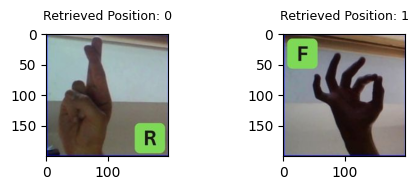

Response: To sign the letter "R" in American Sign Language (ASL), you would follow the instructions provided: the ring and little finger should be folded against the palm and held down by your thumb, while the index and middle finger are straight and crossed with the index finger in front to form the letter "R."



In [ ]:
from llama_index.core.response.notebook_utils import (
    display_query_and_multimodal_response,
)

display_query_and_multimodal_response(query, response)

### Retriever Evaluation

In this part of the notebook, we will carry out the evaluations of our retrievers. Recall that essentially we have two multi-modal retrievers: one that uses default CLIP image embeddings; and another that uses embeddings of associated gpt-4v text descriptions. Before getting into a quantitative analysis of the performances, we create a visualization of the top-1 retrievals for the `text_desc_retriever` (simply swap out for `clip_retriever` if you want!) on all user queries asking to sign each ASL alphabet letter.

NOTE: since we're not sending retrieved documents to LLaVA, we can set `image_simiarity_top_k` to a value greater than 1. When we perform Generation Evaluation, we will have to again use the `rag_engine` defined above which has this parameter set to 1 for those RAG engines using LLaVA.

In [ ]:
# use as retriever
clip_retriever = asl_index.as_retriever(image_similarity_top_k=2)

# use as retriever
text_desc_retriever = asl_text_desc_index.as_retriever(
    image_similarity_top_k=2
)

#### Visual

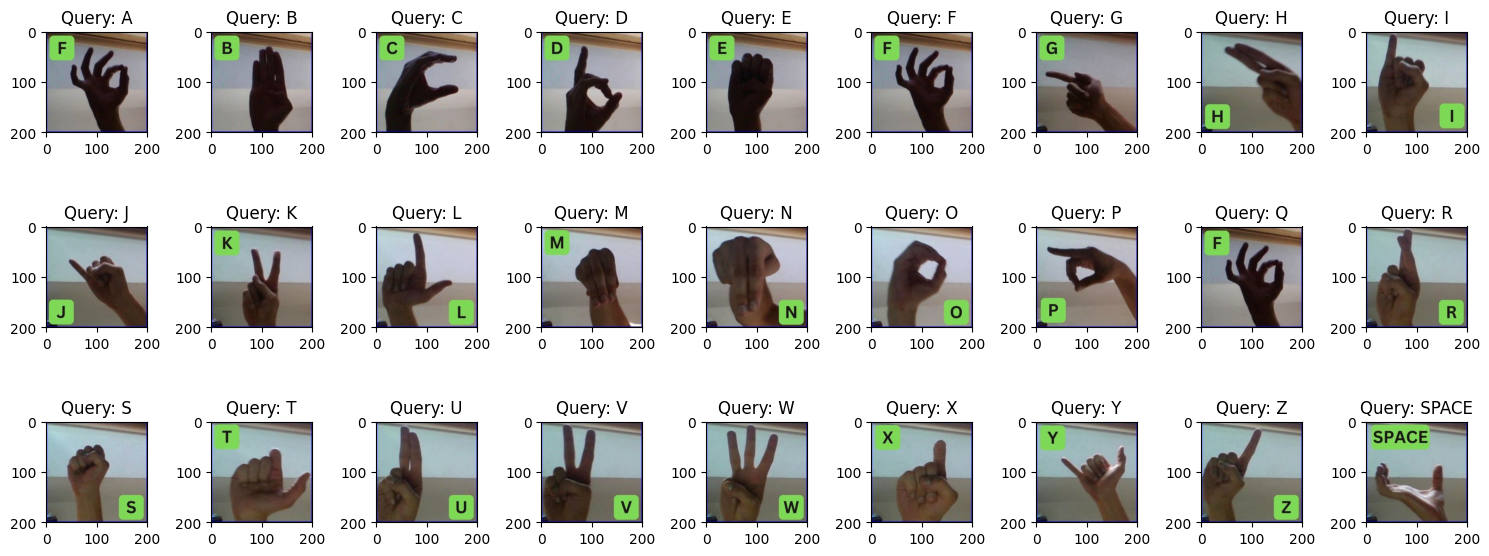

In [ ]:
from llama_index.core.schema import TextNode, ImageNode

f, axarr = plt.subplots(3, 9)
f.set_figheight(6)
f.set_figwidth(15)
ix = 0
for jx, letter in enumerate(asl_text_descriptions.keys()):
    retrieval_results = text_desc_retriever.retrieve(
        QUERY_STR_TEMPLATE.format(symbol=letter)
    )
    image_node = None
    text_node = None
    for r in retrieval_results:
        if isinstance(r.node, TextNode):
            text_node = r
        if isinstance(r.node, ImageNode):
            image_node = r
            break

    img_path = image_node.node.image_path
    image = Image.open(img_path).convert("RGB")
    axarr[int(jx / 9), jx % 9].imshow(image)
    axarr[int(jx / 9), jx % 9].set_title(f"Query: {letter}")

plt.setp(axarr, xticks=[0, 100, 200], yticks=[0, 100, 200])
f.tight_layout()
plt.show()

As you can see, the retriever does a fairly decent job for top-1 retrieval. Now, we move onto a quantative analysis of retriever performance.

#### Quantitative: Hit Rate and MRR 

In our blog (linked at the very beginning of this notebook), we mentioned that a sensible approach to evaluating multi-modal retrievers is compute the usual retrieval eval metrics on image and text retrieval separately. This leaves you of course with double the amount of evaluation metrics as you would be left with in the text-only case, but doing so gives you the important ability to debug your RAG/retriever in a more fine-grained fashion. If you want a single metric, then applying a weighted average with weights tailored to your needs would seem to be a reasonable choice.

To carry all of this out, we make use of the `MultiModalRetrieverEvaluator` which is similar to its uni-modal counterpart, with the difference being that it can handle `image` and `text` retrieval evaluation separately, which is again what we want to do here. 

In [ ]:
from llama_index.core.evaluation import MultiModalRetrieverEvaluator

clip_retriever_evaluator = MultiModalRetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=clip_retriever
)

text_desc_retriever_evaluator = MultiModalRetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=text_desc_retriever
)

One important thing to note when computing evaluation is that you very often need ground-truth (or sometimes also called labelled) data. For retrieval, this labelled data takes the form of `query`, `expected_ids` pairs, where the former is the user query and the latter represents the nodes (represented by their ids) that should be retrieved.

For this guide, we write a specific helper function to build the `LabelledQADataset` object, which is precisely what we need.

In [ ]:
import uuid
import re
from llama_index.core.evaluation import LabelledQADataset


def asl_create_labelled_retrieval_dataset(
    reg_ex, nodes, mode
) -> LabelledQADataset:
    """Returns a QALabelledDataset that provides the expected node IDs
    for every query.

    NOTE: this is specific to the ASL use-case.
    """
    queries = {}
    relevant_docs = {}
    for node in nodes:
        # find the letter associated with the image/text node
        if mode == "image":
            string_to_search = node.metadata["file_path"]
        elif mode == "text":
            string_to_search = node.text
        else:
            raise ValueError(
                "Unsupported mode. Please enter 'image' or 'text'."
            )
        match = re.search(reg_ex, string_to_search)
        if match:
            # build the query
            query = QUERY_STR_TEMPLATE.format(symbol=match.group(1))
            id_ = str(uuid.uuid4())
            # store the query and expected ids pair
            queries[id_] = query
            relevant_docs[id_] = [node.id_]

    return LabelledQADataset(
        queries=queries, relevant_docs=relevant_docs, corpus={}, mode=mode
    )

In [ ]:
# labelled dataset for image retrieval with asl_index.as_retriever()
qa_dataset_image = asl_create_labelled_retrieval_dataset(
    r"(?:([A-Z]+).jpg)", image_nodes, "image"
)

# labelled dataset for text retrieval with asl_index.as_retriever()
qa_dataset_text = asl_create_labelled_retrieval_dataset(
    r"(?:To sign ([A-Z]+) in ASL:)", text_nodes, "text"
)

# labelled dataset for text-desc with asl_text_desc_index.as_retriever()
qa_dataset_text_desc = asl_create_labelled_retrieval_dataset(
    r"(?:([A-Z]+).jpg)", image_with_text_nodes, "image"
)

Now with our ground-truth data in hand, we can invoke the `evaluate_dataset` (or its `async` version) method of our `MultiModalRetrieverEvaluator`.

In [ ]:
eval_results_image = await clip_retriever_evaluator.aevaluate_dataset(
    qa_dataset_image
)
eval_results_text = await clip_retriever_evaluator.aevaluate_dataset(
    qa_dataset_text
)
eval_results_text_desc = await text_desc_retriever_evaluator.aevaluate_dataset(
    qa_dataset_text_desc
)

And, we'll make use of another notebook utility function `get_retrieval_results_df`, which will nicely render our evaluation results into a pandas DataFrame.

In [ ]:
from llama_index.core.evaluation import get_retrieval_results_df

get_retrieval_results_df(
    names=["asl_index-image", "asl_index-text", "asl_text_desc_index"],
    results_arr=[
        eval_results_image,
        eval_results_text,
        eval_results_text_desc,
    ],
)

,retrievers,hit_rate,mrr
0,asl_index-image,0.814815,0.814815
1,asl_index-text,1.000000,1.000000
2,asl_text_desc_index,0.925926,0.925926


#### Observations

- As we can see, the text retrieval of the `asl_index` retriever is perfect. This should be expected the very similar `QUERY_STR_TEMPLATE` and `text_format_str` used to create the texts stored in `text_nodes`.
- CLIP embeddings for images does fairly well, though it appears that in this case the embedding reprentations emanating from the GPT-4V text descriptions leads to better retrieval performance.
- Interestingly, both retrievers when do retrieve the right image, supply it in the initial position, which is why `hit_rate` and `mrr` are equivalent for both.

### Generation Evaluation

Let's now move onto evaluating the Generated responses. For this, we consider our 4 priorly built Multi-Modal RAG systems:

- `mm_clip_gpt4v` = Multi-Modal RAG with CLIP image encoder, lmm = GPT-4V using both `image_nodes` and `text_nodes`
- `mm_clip_llava` = Multi-Modal RAG with CLIP image encoder, lmm = LLaVA using both `image_nodes` and `text_nodes`
- `mm_text_desc_gpt4v` = Multi-Modal RAG with text-desc + ada image encoder, lmm = GPT-4V using both `image_with_text_nodes` and `text_nodes`
- `mm_text_desc_llava` = Multi-Modal RAG with text-desc + ada image encoder, lmm = LLaVA using both `image_with_text_nodes` and `text_nodes`

As for the case of retriever evaluation, we too now need a ground-truth data for evaluating the generated response. (Note that not all evaluation methods required ground-truth, but we'll be using "Correctness" which requires a reference answer to compare the generated ones against.

#### Reference (Ground-Truth) Data
For this, we source another set of text descriptions of the hand gestures for ASL. We found these to be more descriptive and felt they could very well represent reference answers to our ASL query. The source: https://www.signingtime.com/dictionary/category/letters/, which have been pulled and stored in `human_responses.json` that is again included in the data zip download linked at the very beginning of this notebook.

In [ ]:
# references (ground-truth) for our answers
with open("asl_data/human_responses.json") as json_file:
    human_answers = json.load(json_file)

#### Generate Responses To ALL Queries For Each System

Now we will loop through all of the queries and pass these along to all of the 4 RAGs (i.e. `QueryEngine.query()` interface).

In [ ]:
#######################################################################
## Set load_previous_responses to True if you would rather use       ##
## previously generated responses for all rags. The json is part of  ##
## the .zip download                                                 ##
#######################################################################

load_previous_responses = True

In [ ]:
import time
import tqdm

if not load_previous_responses:
    response_data = []
    for letter in tqdm.tqdm(asl_text_descriptions.keys()):
        data_entry = {}
        query = QUERY_STR_TEMPLATE.format(symbol=letter)
        data_entry["query"] = query

        responses = {}
        for name, engine in rag_engines.items():
            this_response = {}
            result = engine.query(query)
            this_response["response"] = result.response

            sources = {}
            source_image_nodes = []
            source_text_nodes = []

            # image sources
            source_image_nodes = [
                score_img_node.node.metadata["file_path"]
                for score_img_node in result.metadata["image_nodes"]
            ]

            # text sources
            source_text_nodes = [
                score_text_node.node.text
                for score_text_node in result.metadata["text_nodes"]
            ]

            sources["images"] = source_image_nodes
            sources["texts"] = source_text_nodes
            this_response["sources"] = sources

            responses[name] = this_response
        data_entry["responses"] = responses
        response_data.append(data_entry)

    # save expensive gpt-4v responses
    with open("expensive_response_data.json", "w") as json_file:
        json.dump(response_data, json_file)
else:
    # load up previously saved image descriptions
    with open("asl_data/expensive_response_data.json") as json_file:
        response_data = json.load(json_file)

### Correctness, Faithfulness, Relevancy

With the generated responses in hand (stored in a custom data object tailored for this ASL use case, namely: `response_data`). We can now compute metrics for their evaluation:
- Correctness (LLM-As-A-Judge):
- Faithfulness (LMM-As-A-Judge):
- Relevancy (LMM-As-A-Judge):

To compute all three, we prompt another generative model to provide a score assessing each of their own criterion. For Correctness, since we're not considering context, then the judge is an LLM. In contrast, to compute Faithfulness and Relevancy, we're required to pass in the context, meaning both images and text that was supplied to the RAG to generate the response in the first place. As a result of this requirement to pass in both image and text, the judges for Faithfulness and Relevancy must be an LMM (or Multi-Modal LLM).

We have these abstractions in our `evaluation` module, and will demonstrate their usage in looping over all of the generated responses.

In [ ]:
from llama_index.llms.openai import OpenAI
from llama_index.core.evaluation import CorrectnessEvaluator
from llama_index.core.evaluation.multi_modal import (
    MultiModalRelevancyEvaluator,
    MultiModalFaithfulnessEvaluator,
)

import os

judges = {}

judges["correctness"] = CorrectnessEvaluator(
    llm=OpenAI(temperature=0, model="gpt-4"),
)

judges["relevancy"] = MultiModalRelevancyEvaluator(
    multi_modal_llm=OpenAIMultiModal(
        model="gpt-4o",
        max_new_tokens=300,
    )
)

judges["faithfulness"] = MultiModalFaithfulnessEvaluator(
    multi_modal_llm=OpenAIMultiModal(
        model="gpt-4o",
        max_new_tokens=300,
    )
)

In [ ]:
#######################################################################
## This section of the notebook can make a total of ~200 GPT-4V      ##
## which is heavily rate limited (100 per day). To follow along,     ##
## with previous generated evaluations set load_previous_evaluations ##
## to True. To test out the evaluation execution, set number_evals   ##
## to any number between (1-27). The json is part of the .zip        ##
## download                                                          ##
#######################################################################

load_previous_evaluations = True
number_evals = 27

In [ ]:
if not load_previous_evaluations:
    evals = {
        "names": [],
        "correctness": [],
        "relevancy": [],
        "faithfulness": [],
    }

    # loop through all responses and evaluate them
    for data_entry in tqdm.tqdm(response_data[:number_evals]):
        reg_ex = r"(?:How can I sign a ([A-Z]+)?)"
        match = re.search(reg_ex, data_entry["query"])

        batch_names = []
        batch_correctness = []
        batch_relevancy = []
        batch_faithfulness = []
        if match:
            letter = match.group(1)
            reference_answer = human_answers[letter]
            for rag_name, rag_response_data in data_entry["responses"].items():
                correctness_result = await judges["correctness"].aevaluate(
                    query=data_entry["query"],
                    response=rag_response_data["response"],
                    reference=reference_answer,
                )

                relevancy_result = judges["relevancy"].evaluate(
                    query=data_entry["query"],
                    response=rag_response_data["response"],
                    contexts=rag_response_data["sources"]["texts"],
                    image_paths=rag_response_data["sources"]["images"],
                )

                faithfulness_result = judges["faithfulness"].evaluate(
                    query=data_entry["query"],
                    response=rag_response_data["response"],
                    contexts=rag_response_data["sources"]["texts"],
                    image_paths=rag_response_data["sources"]["images"],
                )

                batch_names.append(rag_name)
                batch_correctness.append(correctness_result)
                batch_relevancy.append(relevancy_result)
                batch_faithfulness.append(faithfulness_result)

            evals["names"] += batch_names
            evals["correctness"] += batch_correctness
            evals["relevancy"] += batch_relevancy
            evals["faithfulness"] += batch_faithfulness

    # save evaluations
    evaluations_objects = {
        "names": evals["names"],
        "correctness": [e.dict() for e in evals["correctness"]],
        "faithfulness": [e.dict() for e in evals["faithfulness"]],
        "relevancy": [e.dict() for e in evals["relevancy"]],
    }
    with open("asl_data/evaluations.json", "w") as json_file:
        json.dump(evaluations_objects, json_file)
else:
from llama_index.core.evaluation import EvaluationResult

    # load up previously saved image descriptions
    with open("asl_data/evaluations.json") as json_file:
        evaluations_objects = json.load(json_file)

    evals = {}
    evals["names"] = evaluations_objects["names"]
    evals["correctness"] = [
        EvaluationResult.parse_obj(e)
        for e in evaluations_objects["correctness"]
    ]
    evals["faithfulness"] = [
        EvaluationResult.parse_obj(e)
        for e in evaluations_objects["faithfulness"]
    ]
    evals["relevancy"] = [
        EvaluationResult.parse_obj(e) for e in evaluations_objects["relevancy"]
    ]

To view these results, we yet again make use of notebook utility function `get_eval_results_df`.

In [ ]:
from llama_index.core.evaluation.notebook_utils import get_eval_results_df

deep_eval_df, mean_correctness_df = get_eval_results_df(
    evals["names"], evals["correctness"], metric="correctness"
)
_, mean_relevancy_df = get_eval_results_df(
    evals["names"], evals["relevancy"], metric="relevancy"
)
_, mean_faithfulness_df = get_eval_results_df(
    evals["names"], evals["faithfulness"], metric="faithfulness"
)

mean_scores_df = pd.concat(
    [
        mean_correctness_df.reset_index(),
        mean_relevancy_df.reset_index(),
        mean_faithfulness_df.reset_index(),
    ],
    axis=0,
    ignore_index=True,
)
mean_scores_df = mean_scores_df.set_index("index")
mean_scores_df.index = mean_scores_df.index.set_names(["metrics"])

In [ ]:
print(deep_eval_df[:4])

,rag,query,scores,feedbacks
0,mm_clip_gpt4v,How can I sign a A?.,4.500000,"The generated answer is relevant and mostly correct. It accurately describes how to sign the letter 'A' in ASL, which matches the user query. However, it includes unnecessary information about images that were not mentioned in the user query, which slightly detracts from its overall correctness."
1,mm_clip_llava,How can I sign a A?.,4.500000,"The generated answer is relevant and mostly correct. It provides the necessary steps to sign the letter 'A' in ASL, but it lacks the additional information about the hand position and the difference between 'A' and 'S' that the reference answer provides."
2,mm_text_desc_gpt4v,How can I sign a A?.,4.500000,"The generated answer is relevant and mostly correct. It provides a clear description of how to sign the letter 'A' in American Sign Language, which matches the reference answer. However, it starts with an unnecessary statement about the lack of images, which is not relevant to the user's query."
3,mm_text_desc_llava,How can I sign a A?.,4.500000,"The generated answer is relevant and almost fully correct. It accurately describes how to sign the letter 'A' in American Sign Language. However, it lacks the detail about the position of the hand (at shoulder height with palm facing out) that is present in the reference answer."


In [ ]:
mean_scores_df

rag,mm_clip_gpt4v,mm_clip_llava,mm_text_desc_gpt4v,mm_text_desc_llava
metrics,,,,
mean_correctness_score,3.685185,4.092593,3.722222,3.870370
mean_relevancy_score,0.777778,0.851852,0.703704,0.740741
mean_faithfulness_score,0.777778,0.888889,0.851852,0.851852


#### Observations

- It appears that RAGs that use LLaVA are yield better Correctness, Relevancy, and Faithfulness scores than those that use GPT-4V
- Upon some inspection of the responses, we note that GPT-4V answers for `SPACE` with the following eveno though the image was correctly retrieved: "I'm sorry, but I'm unable to answer the query based on the images provided as the system doesn't allow me to visually analyze images at the moment. However, according to the context provided, to sign "SPACE" in ASL, you should hold your palm to the sky with your fingers curled upwards and thumb pointing up."
- These types of generated responses could be the reason why the judges are not scoring GPT-4V generations as high as that for LLaVA. A more thorough analysis would involve digging into the generated responses more deeply, and perhaps adjusting with the generation prompts and even the evaluation prompts.

## In Conclusion

In this notebook we demonstrated how one can evaluate both the Retriever and Generator of a Multi-Modal RAG. Specifically we applied existing `llama-index` evaluation tools on the ASL use case in an effort to illustrate how they could be applied to your evaluation needs. Note that Multi-Modal LLMs should still be considered beta, and special standards of care should be applied if they are going to be used in production systems to evaluate multi-modal responses.